In [1]:
import sys
sys.path.append('/net/hypernova/data2/BOOMPJE/code/ic_generation/')
import subprocess

import numpy as np
from astropy.cosmology import WMAP9 as cosmo
from collections import OrderedDict
from scipy.interpolate import griddata
import read_tipsy
import os
import sphviewer
from sphviewer.tools import QuickView, Blend
from sklearn.neighbors import KernelDensity

import matplotlib.pyplot as plt
import matplotlib.tri as tri
from matplotlib import animation, rc
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
plt.rcParams['figure.dpi'] = 360
matplotlib.rcParams['animation.embed_limit'] = 2**128
matplotlib.rcParams['text.usetex'] = True
rc("animation", html = "jshtml")

#### Plots

In [ ]:
h, m, x, y, z, vx, vy, vz, ids = read_tipsy.read_file('/net/hypernova/data2/BOOMPJE/merging_10_1073713/evolution_00000.1600-0')
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.scatter(x, y, z, s=1e-13, c='black')
plt.title('merging_10_1073713/evolution_00000.1600-0')
plt.tight_layout()
plt.show()

In [ ]:
h1, m1, x1, y1, z1, vx1, vy1, vz1, ids1 = read_tipsy.read_file('/net/hypernova/data2/BOOMPJE/merging_459_1073710/evolution_00010.8002-0')
fig = plt.figure(figsize=(10,10))
plt.subplots_adjust(wspace=0.3)

ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.scatter(x, y, z, s=1e-13, c='black', label='initial')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend()

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter(x1, y1, z1, s=1e-13, c='royalblue', label='final')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend()

plt.show()

### Read param

In [2]:
def read_parameters(sim_path):
    log = {}
    with open(f'/net/hypernova/data2/BOOMPJE/{sim_path}/parameters.log') as f:
        f = f.readlines()
        for line in f:
            key, value = line.strip().split(':')
            try:
                log[key.strip()] = float(value.strip())
            except:
                log[key.strip()] = value.strip()
    return log

param = read_parameters('merging_429_1073710')

### Animation

In [ ]:
h, m, x, y, z, vx, vy, vz, ids = read_tipsy.read_file('/net/hypernova/data2/BOOMPJE/merging_10_1073713/evolution_00000.1600-0')

plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(7, 7))
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_title(f'Simulation {int(param['simulation_id'])}' + '\n' + fr'$t$ = t ' + r'$H_{0}^{-1}$', y=1.03)
pos = np.array([x,y,z]).T
qv = QuickView(pos, extent=[-3,3,-3,3], r='infinity', plot=False)
img = qv.get_image()
ax.imshow(img, extent=qv.get_extent(), origin='lower', cmap='gist_heat')

ax.set_aspect('equal')

m_r = r'$M_{s}/M_{c}$ = ' + f'${round(param['mass_ratio'], 4)}$'
c_con = r'$c_{cen}$ = ' + f'${round(param['cen_concentration'], 4)}$'
s_con = r'$c_{sat}$ = ' + f'${round(param['sat_concentration'], 4)}$'
cen_slope = r'$\alpha_{cen}$ = ' + f'${round(param['cen_inner_slope'], 4)}$'
sat_slope = r'$\alpha_{sat}$ = ' + f'${round(param['sat_inner_slope'], 4)}$'
per_d = r'$r_{p}$ = ' + f'${round(param['pericentre_distance'], 4)}$'
e = r'$e$ = ' + f'${round(param['eccentricity'], 4)}$'
ax.text(2.7, 2.7, f'{m_r}\n{c_con}\n{s_con}\n{cen_slope}\n{sat_slope}\n{per_d}\n{e}', ha='right', va='top')
plt.show()

### Separate halos

In [ ]:
h1, m1, x1, y1, z1, vx1, vy1, vz1, ids1 = read_tipsy.read_file('/net/hypernova/data2/BOOMPJE/merging_10_1073713/evolution_00017.5503-0')
h, m, x, y, z, vx, vy, vz, ids = read_tipsy.read_file('/net/hypernova/data2/BOOMPJE/merging_10_1073713/stacked_objects')

In [ ]:
m_cen = sum(m)/(1+param['mass_ratio'])
n_cen = int(m_cen/m[0])
n_sat = len(m)-n_cen

plt.scatter(x[:n_sat], y[:n_sat], s=1e-5, label='satellite (blue)') #!cen
#plt.scatter(x[n_sat:], y[n_sat:], s=1e-13, label='central (yellow)') #!sat
plt.legend()
plt.xlim(-2.5, 2.5)
plt.ylim(-2, 2)
plt.show()

In [ ]:
m_cen = sum(m)/(1+param['mass_ratio'])
n_cen = int(m_cen/m[0])
n_sat = len(m)-n_cen

sat_ids = ids[:n_sat]
sat_mask = np.isin(ids, sat_ids)

halos = {
    'cen': {
        'pos': np.column_stack((x[~sat_mask], y[~sat_mask], z[~sat_mask])),
        'vel': np.column_stack((vx[~sat_mask], vy[~sat_mask], vz[~sat_mask])),
        'm': m[~sat_mask]},
    'sat': {
        'pos': np.column_stack((x[sat_mask], y[sat_mask], z[sat_mask])),
        'vel': np.column_stack((vx[sat_mask], vy[sat_mask], vz[sat_mask])),
        'm': m[sat_mask]}}

In [ ]:
plt.scatter(halos['cen']['pos'][:,0], halos['cen']['pos'][:,1], s=1e-13, label='satellite (blue)') #!cen
plt.scatter(halos['sat']['pos'][:,0], halos['sat']['pos'][:,1], s=1e-13, label='central (yellow)') #!sat
plt.xlim(-2.5, 2.5)
plt.ylim(-2, 2)
plt.legend()
plt.show()

In [3]:
def separate_ids(sim_path):
    _, m, _, _, _, _, _, _, ids = read_tipsy.read_file(f'/net/hypernova/data2/BOOMPJE/{sim_path[:19]}/stacked_objects')
    ids.sort()
    cen_ids = ids[:int(1e6)]
    return cen_ids

def separate_halos(cen_ids, sim_path):
    _, m, x, y, z, vx, vy, vz, ids = read_tipsy.read_file(f'/net/hypernova/data2/BOOMPJE/{sim_path}')
    mask = np.isin(ids, cen_ids)
    halos = {
        'cen': {
            'pos': np.column_stack((x[mask], y[mask], z[mask])),
            'vel': np.column_stack((vx[mask], vy[mask], vz[mask])),
            'm': m[mask]},
        'sat': {
            'pos': np.column_stack((x[~mask], y[~mask], z[~mask])),
            'vel': np.column_stack((vx[~mask], vy[~mask], vz[~mask])),
            'm': m[~mask]}}
    return halos

In [4]:
sim_path = 'merging_0_1072098'
params = read_parameters(sim_path)
ids = separate_ids(sim_path)

def load_data(directory):
    files = [f for f in os.listdir(directory) if f.startswith('evolution')]
    files.sort()
    time = []
    for file in files:
        time.append(float(file[10:-2]))
    return 15*np.array(time), files #!t=15H0

time, files = load_data(f'/net/hypernova/data2/BOOMPJE/{sim_path}')

In [ ]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
ax.set_xlabel('x')
ax.set_ylabel('y')
halos = separate_halos(ids, f'{sim_path}/evolution_00000.1600-0')
pos_c, pos_s = halos['cen']['pos'].T, halos['sat']['pos'].T
ax.scatter(pos_c[0], pos_c[1], s=1e-13, c='navy')
ax.scatter(pos_s[0], pos_s[1], s=1e-13, c='red')
plt.show()

### $\rho$

In [ ]:
kde = KernelDensity(kernel='gaussian', bandwidth=0.01).fit(halos['cen']['pos'])
kde.get_params()

In [ ]:
x = np.linspace(min(halos['cen']['pos'].T[0]), max(halos['cen']['pos'].T[0]), len(time))
y = np.linspace(min(halos['cen']['pos'].T[1]), max(halos['cen']['pos'].T[1]), len(time))
z = np.linspace(min(halos['cen']['pos'].T[1]), max(halos['cen']['pos'].T[1]), len(time))
log_dens = kde.score_samples(np.array([x,y,z]).T)

In [ ]:
plt.plot(dist, log_dens)

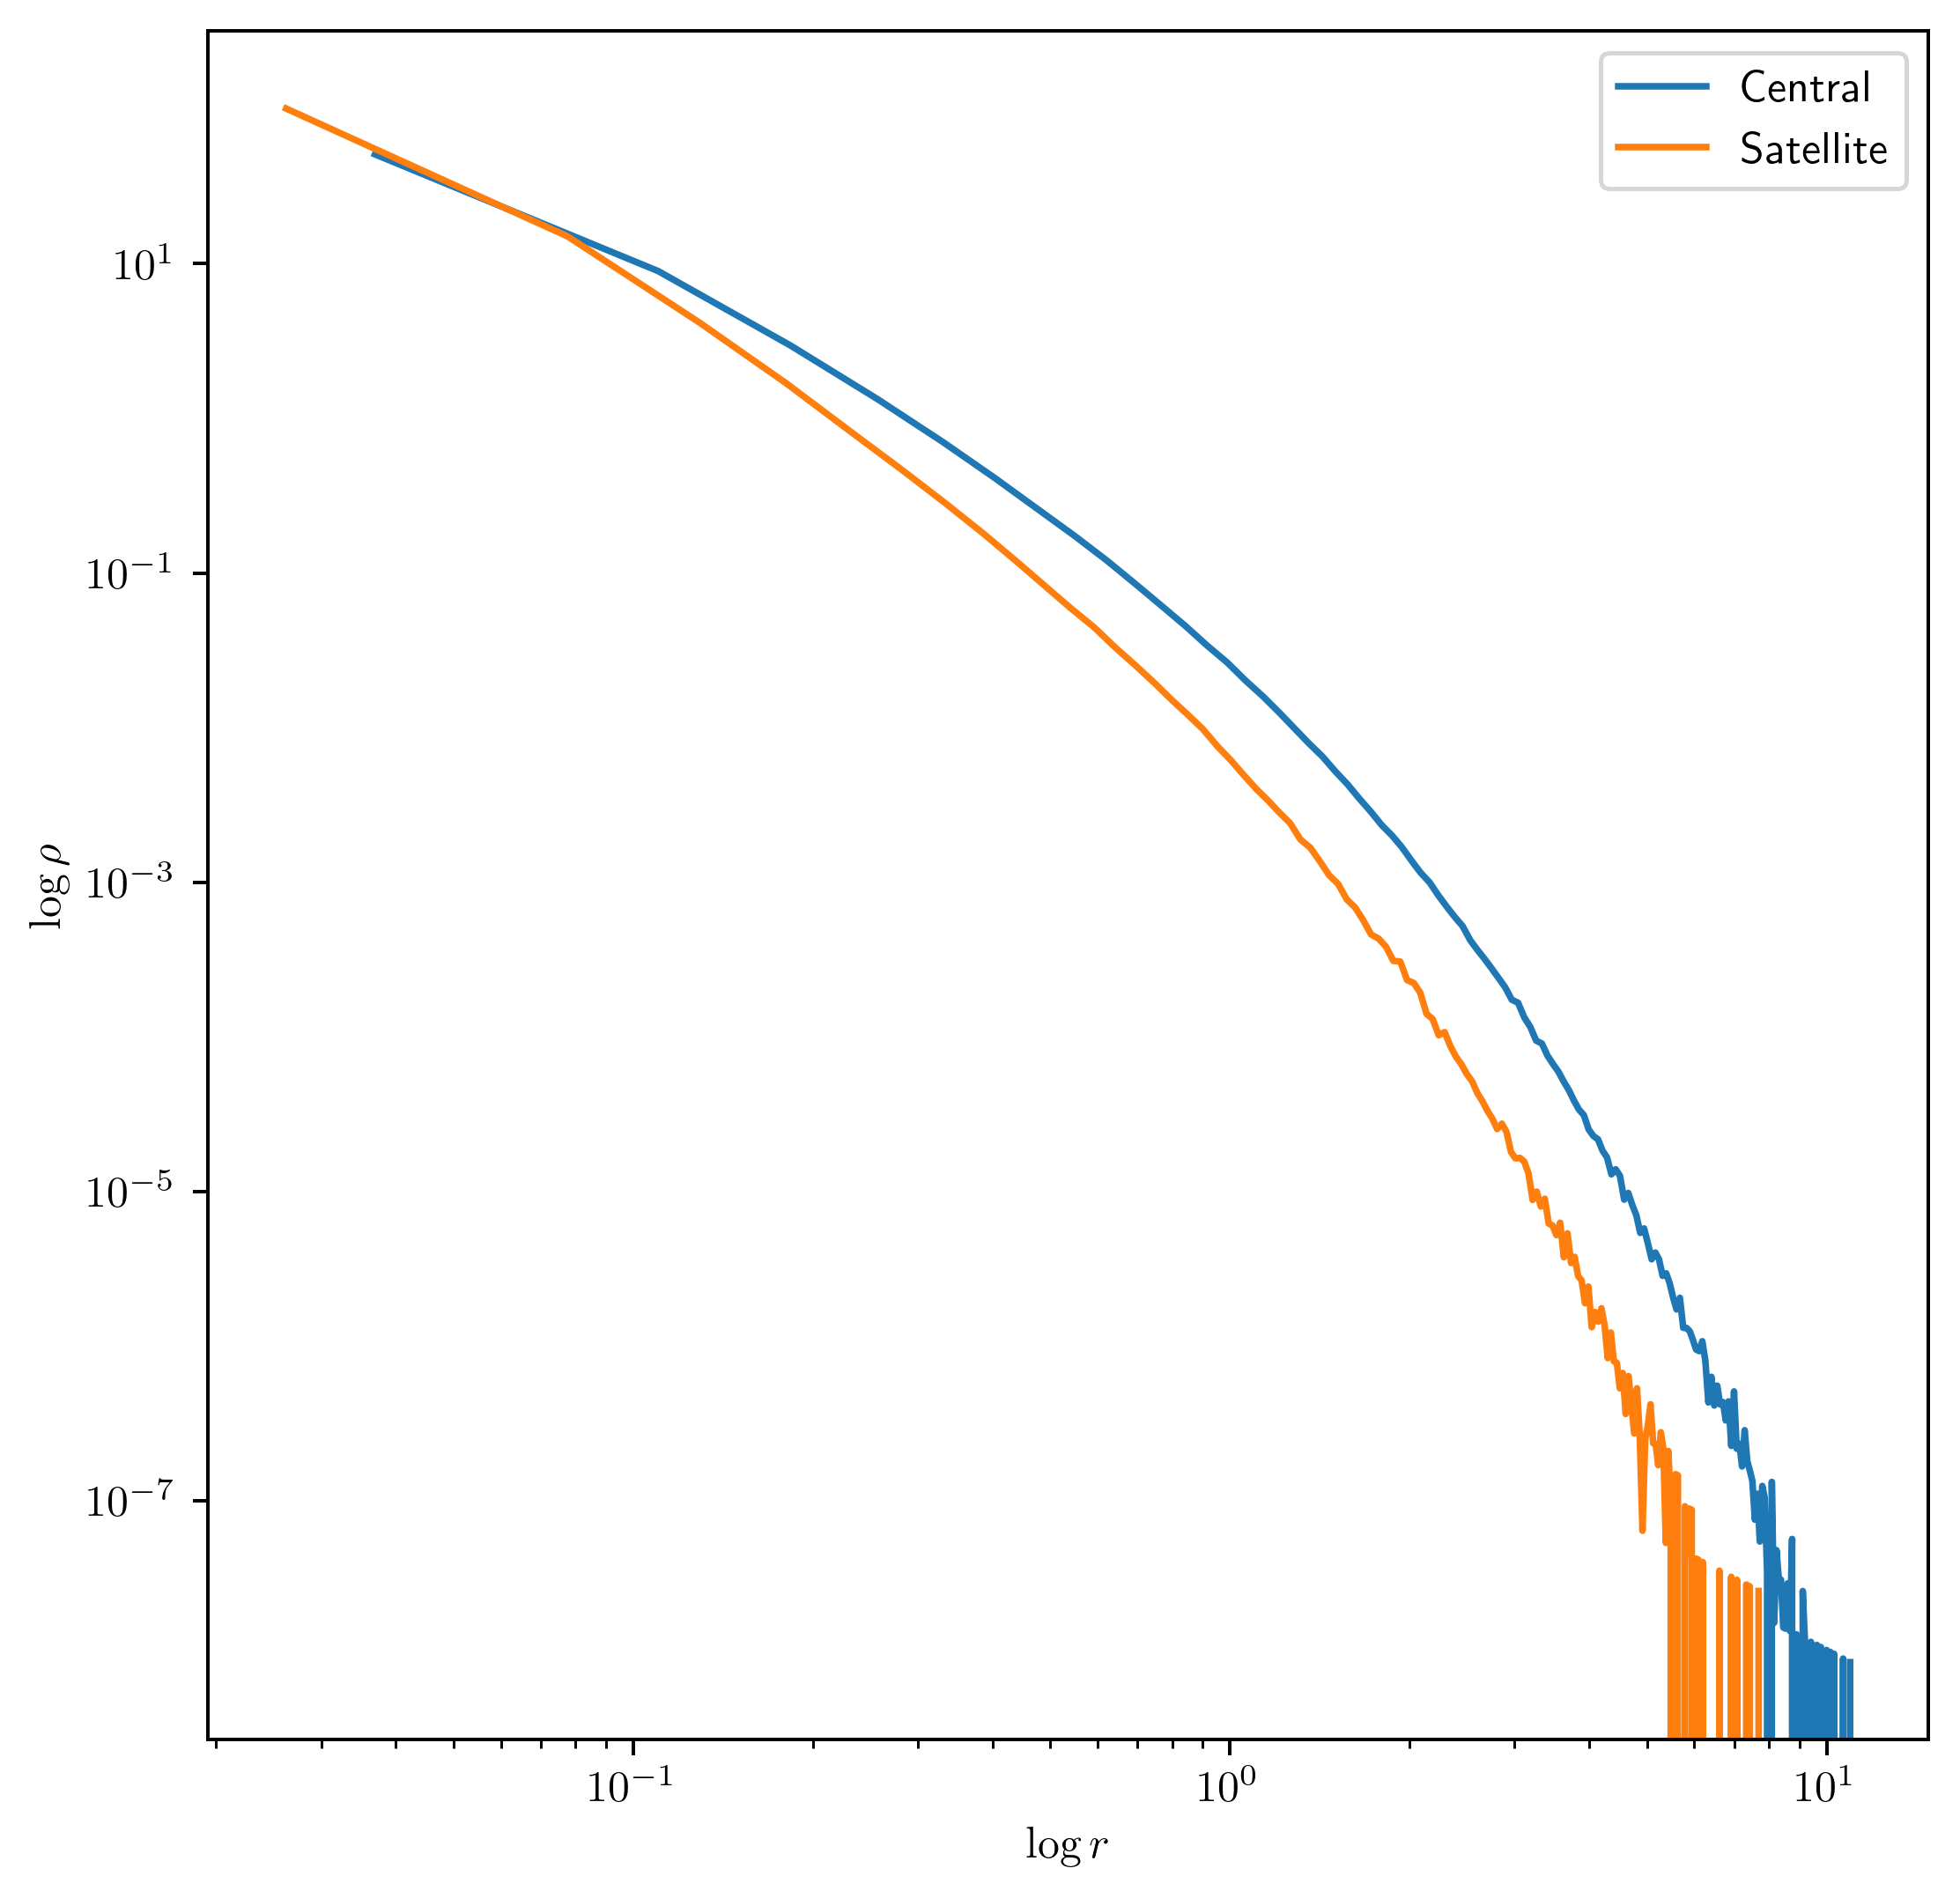

In [11]:
def find_center(positions, masses, radius=0.1, max_iter=100, tol=1e-4):
    center = np.mean(positions, axis=0)
    for _ in range(max_iter):
        distances = np.linalg.norm(positions - center, axis=1)
        mask = distances < radius
        new_center = np.sum(positions[mask].T * masses[mask], axis=1) / np.sum(masses[mask])
        if np.linalg.norm(new_center - center) < tol:
            break
        center = new_center
    return center

def calculate_distances(positions, center):
    distances = np.linalg.norm(positions - center, axis=1)
    return distances

def calculate_mass_density(distances, masses, num_bins=150):
    hist, bin_edges = np.histogram(distances, bins=num_bins, weights=masses)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    bin_volumes = 4/3 * np.pi * (bin_edges[1:]**3 - bin_edges[:-1]**3)
    density = hist / bin_volumes
    return bin_centers, density

def plot_mass_density(bin_centers, density, label):
    plt.plot(bin_centers, density, label=label)

sim_path = 'merging_0_1072098'
cen_ids = separate_ids(sim_path)
halos = separate_halos(cen_ids, sim_path+'/evolution_00000.1600-0')

dense_center_cen = find_center(halos['cen']['pos'], halos['cen']['m'])
dense_center_sat = find_center(halos['sat']['pos'], halos['sat']['m'])

distances_cen = calculate_distances(halos['cen']['pos'], dense_center_cen)
distances_sat = calculate_distances(halos['sat']['pos'], dense_center_sat)

bin_centers_cen, density_cen = calculate_mass_density(distances_cen, halos['cen']['m'])
bin_centers_sat, density_sat = calculate_mass_density(distances_sat, halos['sat']['m'])


fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)

ax.plot(bin_centers_cen, density_cen, label='Central')
ax.plot(bin_centers_sat, density_sat, label='Satellite')
#ax.axvline(x=1/params['cen_concentration'], c='red', label=r'$\frac{1}{c_{cen}}$', ls='--')
#ax.axvline(x=1/params['sat_concentration'], c='navy', label=r'$\frac{1}{c_{sat}}$', ls='--')

plt.xlabel(r'$\log{r}$')
plt.ylabel(r'$\log{\rho}$')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

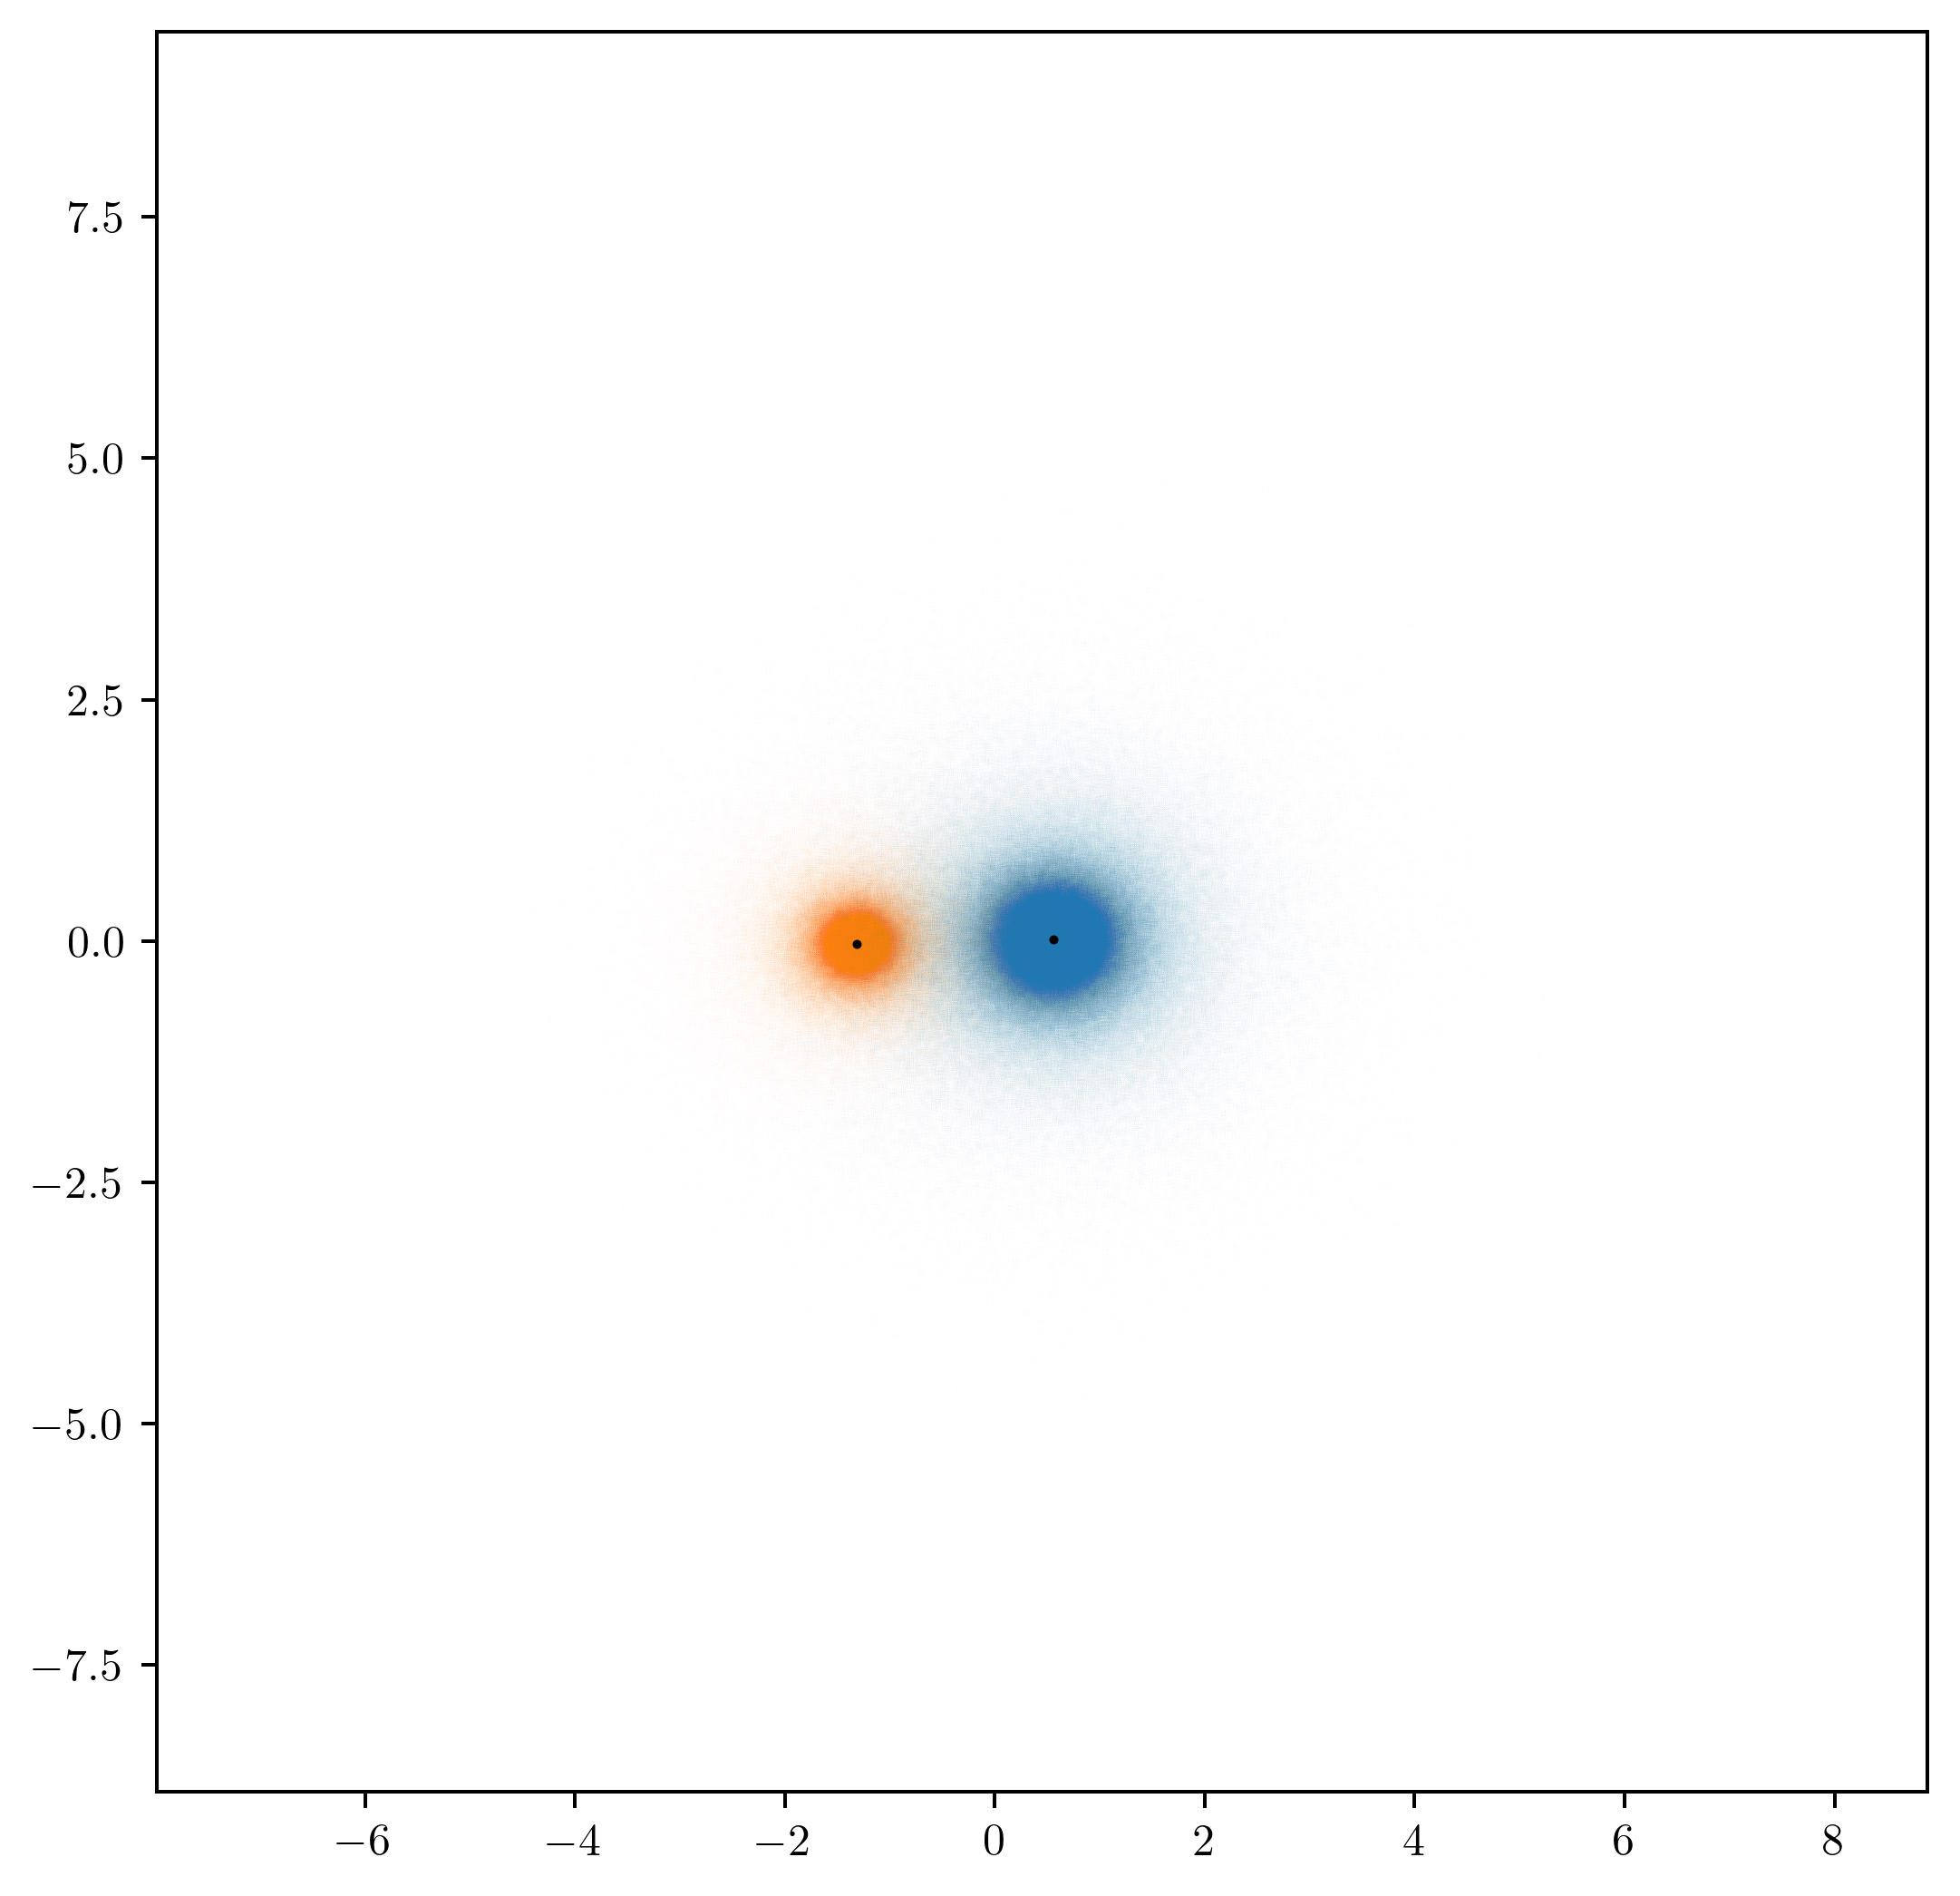

In [14]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)

ax.scatter(halos['cen']['pos'].T[0], halos['cen']['pos'].T[1], s=1e-13)
ax.scatter(halos['sat']['pos'].T[0], halos['sat']['pos'].T[1], s=1e-13)

ax.scatter(dense_center_cen[0], dense_center_cen[1], s=1, c='black')
ax.scatter(dense_center_sat[0], dense_center_sat[1], s=1, c='black')
plt.show()

### Contour plot

In [ ]:
x, y, z = halos['cen']['pos'][:,0], halos['cen']['pos'][:,1], halos['cen']['pos'][:,2]

triang = tri.Triangulation(x,y)
interpolator = tri.LinearTriInterpolator(triang, z)

In [ ]:
xi = np.linspace(min(x), max(x), int(len(x)*0.001))
yi = np.linspace(min(y), max(y), int(len(y)*0.001))

Xi, Yi = np.meshgrid(xi, yi)
zi = interpolator(Xi, Yi)

In [ ]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.contour(xi, yi, zi, levels=15)
ax.scatter(x, y, s=1e-13, c='black')
plt.show()

### Stream plot

In [ ]:
h, m, x, y, z, vx, vy, vz, ids = read_tipsy.read_file('/net/hypernova/data2/BOOMPJE/merging_10_1073713/evolution_00000.1600-0')
vfield, pos, vel = [], np.array([x,y,z]).T, np.array([vx,vy,vz]).T

qv = QuickView(pos, r='infinity', extent=[-5,5,-5,5], plot=False, logscale=False)
density_field = qv.get_image()
extent = qv.get_extent()

for i in range(2):
    qv = QuickView(pos, vel[:,i], r='infinity', extent=[-3,3,-3,3], plot=False, logscale=False)
    vfield.append(qv.get_image()/density_field)

In [ ]:
fig = plt.figure(1, figsize=(7,7))
ax = fig.add_subplot()

X = np.linspace(extent[0], extent[1], 500)
Y = np.linspace(extent[2], extent[3], 500)

ax.imshow(np.log10(density_field), origin='lower', extent=extent, cmap='bone')
v = np.log10(np.sqrt(vfield[0]**2 + vfield[1]**2))
color =  v/np.max(v)

streams = ax.streamplot(X, Y, vfield[0], vfield[1], density=1.5, color=color, cmap='gist_heat', linewidth=1.3, arrowsize=1.2)
ax.set_xlim(extent[0], extent[1])
ax.set_xlim(extent[2], extent[3])
ax.set_title(f'Simulation {int(params['simulation_id'])}\nVelocity streamplot', y=1.03)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.minorticks_on()
plt.show()

### r vs t

In [ ]:
cm_c = np.sum(halos['cen']['pos'].T*halos['cen']['m'], axis=1)/sum(halos['cen']['m'])
cm_s = np.sum(halos['sat']['pos'].T*halos['sat']['m'], axis=1)/sum(halos['sat']['m'])

dist = np.linalg.norm(cm_c-cm_s)
dist

In [ ]:
rp, e = param['pericentre_distance'], param['eccentricity']
ra = ((1+e)*rp)/(1-e)
rp,ra

In [ ]:
fig, ax = plt.subplots(figsize=(7, 7))
#plt.axvline(x=param['pericentre_distance'], linestyle='--', c='black')
ax.axhline(y=rp, c='red', label=r'$r_{p}$', ls='--')
ax.axhline(y=ra, c='navy', label=r'$r_{a}$', ls='--')
plt.legend()
plt.show()